In [141]:
import os


def warn(*args, **kwargs):
    pass


import warnings

warnings.warn = warn

import matplotlib.pyplot as plt
import pandas as pd

In [154]:
folders = ['icsa-noniid', 'icsa-iid']
exp_data = []

for folder in folders:
    experiments = [subfolder for subfolder in os.listdir(os.getcwd() + '/' + folder)]
    for exp in experiments:
        exp_path = os.getcwd() + '/' + folder + '/' + exp
        if 'FLwithAP_performance_metrics.csv' in os.listdir(exp_path):
            df = pd.read_csv(exp_path + '/FLwithAP_performance_metrics.csv')
            df['F1 Score Over Total Time for FL Round'] = df['Val F1'] / df['Total Time of FL Round']
            clients = list(set(df['Client ID'].tolist()))
            last_client_id = max([int(cl.split('Client ')[1]) for cl in clients])
            model_data = df[df['Val F1'] >= 0]
            exp_data.append((folder + '-' + exp, model_data))

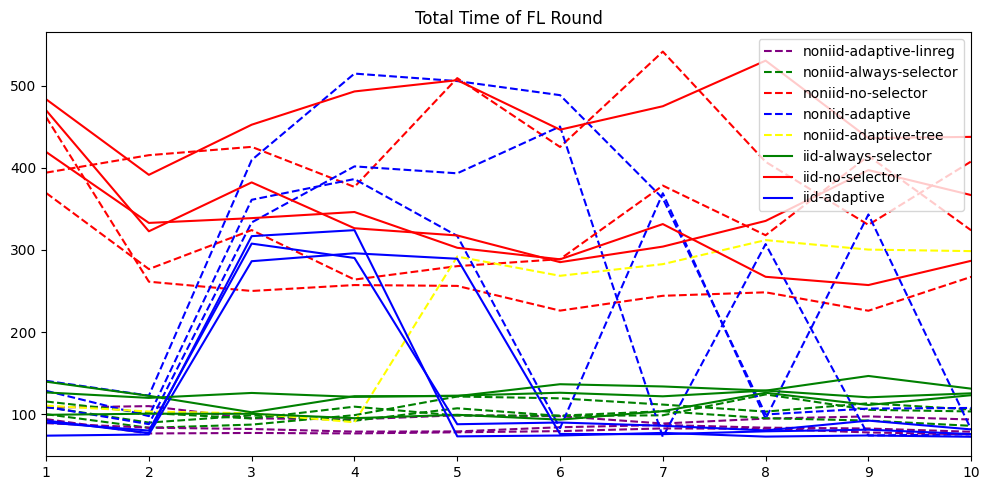

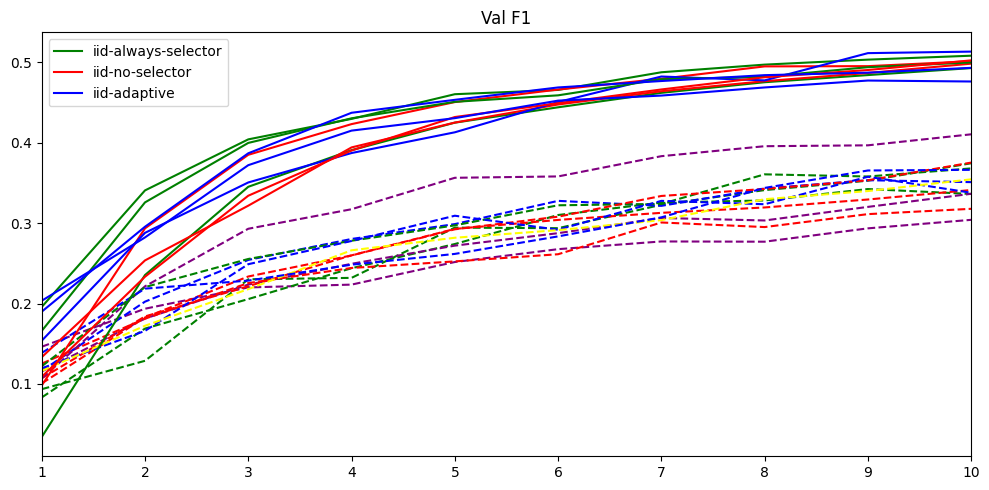

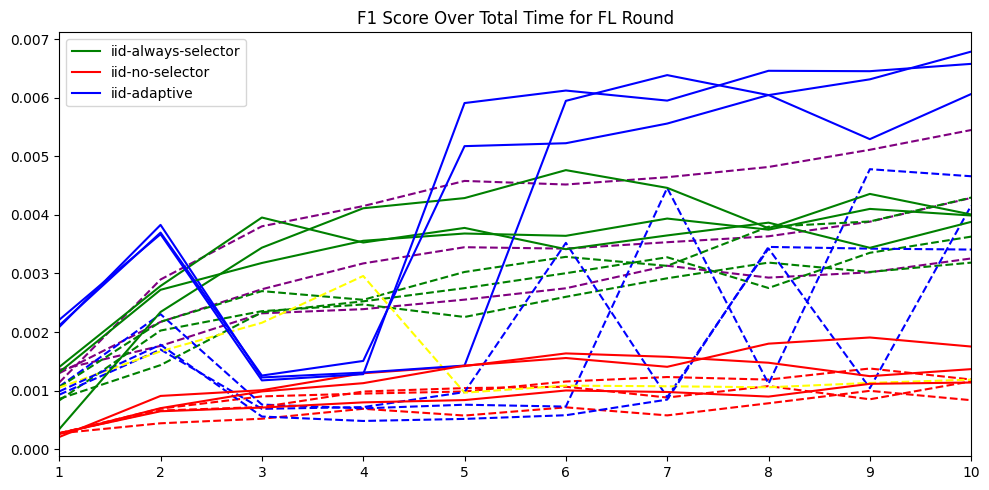

In [155]:
configurations = ['no-selector-icsa-B', 'always-selector-icsa-C', 'adaptive-selector-icsa', 'adaptive-tree-icsa', 'adaptive-linreg-icsa']
selected_confs = []
for folder in folders:
    selected_confs.extend([folder + '-' + conf for conf in configurations])
metrics = ['Total Time of FL Round', 'Val F1', 'F1 Score Over Total Time for FL Round']

colors = {'no-selector-icsa-B': ['red', False, False, 'no-selector'],
          'always-selector-icsa-C': ['green', False, False, 'always-selector'],
          'adaptive-selector-icsa': ['blue', False, False, 'adaptive'],
          'adaptive-selector-icsa-2': ['orange', False, False, 'adaptive-2'],
          'adaptive-tree-icsa': ['yellow', False, False, 'adaptive-tree'], 
          'adaptive-linreg-icsa': ['purple', False, False, 'adaptive-linreg']}

for metric in metrics:
    fig, ax = plt.subplots(figsize=(10, 5))

    for exp, model_data in exp_data:
        conf = exp.split('_')[0].split('iid-')[1]
        noniid = 'noniid' in exp
        style = '--' if noniid else '-'
        label = 'noniid-' + colors[conf][3] if noniid else 'iid-' + colors[conf][3]
        if not (conf in configurations):
            continue
        if noniid and colors[conf][2]:
            ax.plot(model_data['FL Round'], model_data[metric], linestyle=style, color=colors[conf][0])
        elif not noniid and colors[conf][1]:
            ax.plot(model_data['FL Round'], model_data[metric], linestyle=style, color=colors[conf][0])
        else:
            ax.plot(model_data['FL Round'], model_data[metric], linestyle=style, color=colors[conf][0], label=label)
            if noniid:
                colors[conf][2] = True
            else:
                colors[conf][1] = True

    for conf in colors:
        colors[conf][1] = False

    ax.set_title(metric)
    ax.set_xticks([i + 1 for i in range(len(model_data['FL Round']))])
    ax.set_xlim(1, len(model_data['FL Round']))
    ax.legend()

    fig.tight_layout()
    fig.savefig(metric, dpi=300)
    fig.show()

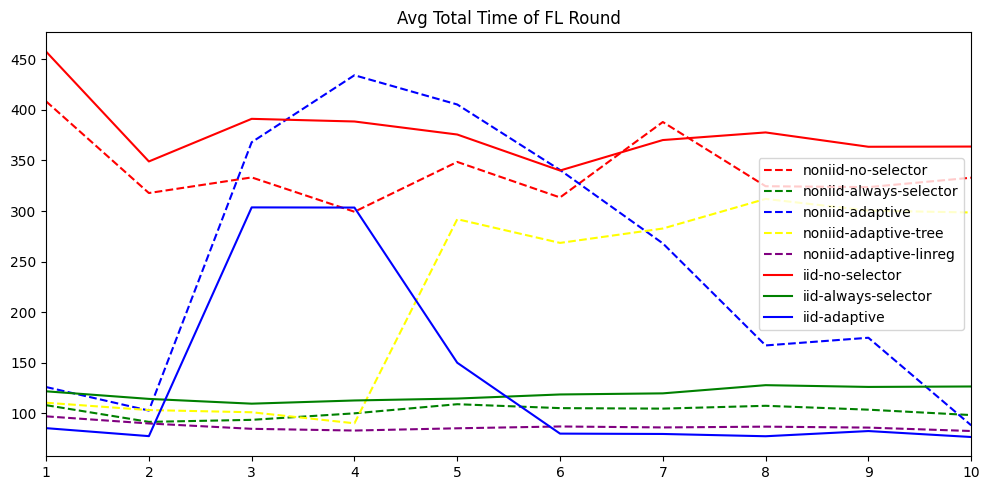

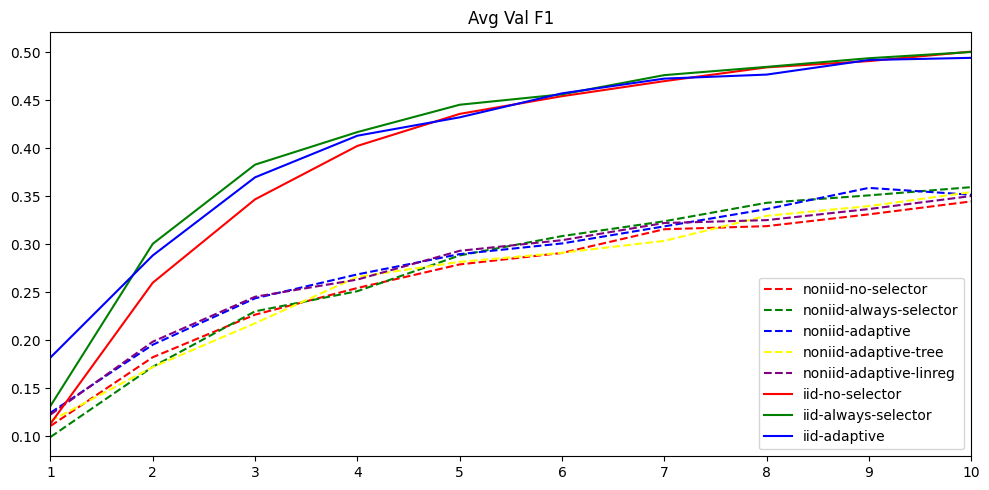

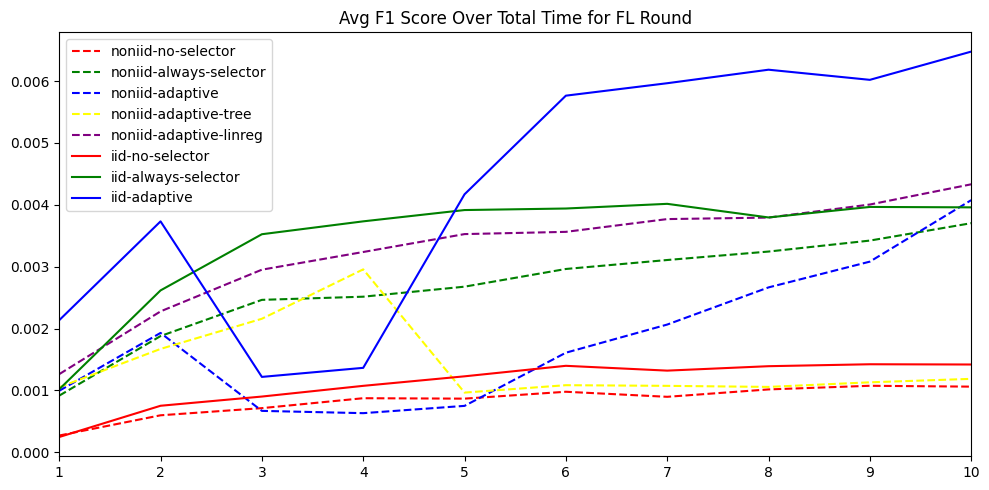

In [156]:
avg_data = {metric: {conf: [] for conf in selected_confs} for metric in metrics}

for metric in metrics:
    fig, ax = plt.subplots(figsize=(10, 5))

    for conf in selected_confs:
        data = [model_data[metric].tolist() for exp, model_data in exp_data if exp.split('_')[0] == conf]
        try:
            for i in range(len(data[0])):
                avg_data[metric][conf].append(sum([v[i] for v in data]) / len(data))
        except IndexError:
            continue

        conf4color = conf.split('iid-')[1]
        noniid = 'noniid' in conf
        style = '--' if noniid else '-'
        label = 'noniid-' + colors[conf4color][3] if noniid else 'iid-' + colors[conf4color][3]
        ax.plot(avg_data[metric][conf], color=colors[conf4color][0], label=label, linestyle=style)

        title = 'Avg ' + metric
        ax.set_title(title)
        ax.set_xticks([i for i in range(len(avg_data[metric][conf]))],
                      labels=[i + 1 for i in range(len(avg_data[metric][conf]))])
        ax.set_xlim(0, len(avg_data[metric][conf]) - 1)
        ax.legend()

        fig.tight_layout()
        fig.savefig(title, dpi=300)
        fig.show()

